# Overview
* Not concearn about the order
* Try to predict current economic phase (not forward)
* Normalized data 
* No Dimensionality  Reduncion
* Not transforming the variables
* Not lagging the variables


In [1]:
import pandas as pd
import numpy as np
import missingno
import matplotlib.pyplot as plt 
import seaborn as sns
plt.style.use('ggplot')
from fredapi import Fred
from utils.key import APIKEY as API_FRED
import utils_FRED_MD.model_evaluation  as me
from utils_FRED_MD.format_datasets import  get_nonNANs_fullsample



In [2]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score ,confusion_matrix ,precision_score, recall_score, f1_score, classification_report ,roc_curve, roc_auc_score ,roc_curve, auc, ConfusionMatrixDisplay , RocCurveDisplay


from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
import statsmodels.api as smf

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import utils_FRED_MD.model_evaluation  as me
SPLIT = 0.7
SEED=42
mms = MinMaxScaler()
scaler = StandardScaler()


In [3]:
help(get_nonNANs_fullsample)

Help on function get_nonNANs_fullsample in module utils_FRED_MD.format_datasets:

get_nonNANs_fullsample(frequency_dataset='monthly', add_USREC=True, max_date='2023-08-01', min_date=None)



In [4]:
df = get_nonNANs_fullsample()
df.head()

Columns dropped: 


,date,RPI,W875RX1,DPCERA3M086SBEA,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,CUSR0000SA0L5,PCEPI,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,INVEST,USREC
0,1959-01-01,2583.560,2426.0,15.188,18235.77392,21.9665,23.3891,22.2688,31.7011,19.0149,...,29.6,15.164,63.517,18.294,10.152,2.13,2.45,2.04,84.2043,0.0
1,1959-02-01,2593.596,2434.8,15.346,18369.56308,22.3966,23.7048,22.4617,31.9337,19.1147,...,29.6,15.179,63.554,18.302,10.167,2.14,2.46,2.05,83.5280,0.0
2,1959-03-01,2610.396,2452.7,15.491,18523.05762,22.7193,23.8483,22.5719,31.9337,19.4890,...,29.6,15.189,63.634,18.289,10.185,2.15,2.45,2.07,81.6405,0.0
3,1959-04-01,2627.446,2470.0,15.435,18534.46600,23.2032,24.1927,22.9026,32.4374,19.6138,...,29.6,15.219,63.698,18.300,10.221,2.16,2.47,2.08,81.8099,0.0
4,1959-05-01,2642.720,2486.4,15.622,18679.66354,23.5528,24.3936,23.1231,32.5925,20.0130,...,29.6,15.227,63.804,18.280,10.238,2.17,2.48,2.08,80.7315,0.0


In [5]:
df.tail()

,date,RPI,W875RX1,DPCERA3M086SBEA,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,CUSR0000SA0L5,PCEPI,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,INVEST,USREC
771,2023-04-01,19030.119,15600.2,115.246,684636.0,103.1274,101.7771,102.4474,103.6524,108.9423,...,291.138,119.893,108.514,118.685,122.165,29.23,33.90,26.04,5243.7520,0.0
772,2023-05-01,19074.384,15636.1,115.400,689158.0,102.7864,101.3461,101.8586,102.8448,109.5420,...,291.510,120.020,108.772,118.279,122.441,29.33,33.97,26.15,5210.2067,0.0
773,2023-06-01,19082.740,15654.8,115.693,690518.0,102.3673,100.6659,100.9632,101.5389,106.0073,...,292.077,120.221,108.390,118.369,122.797,29.52,34.04,26.40,5188.5697,0.0
774,2023-07-01,19087.488,15684.9,116.432,693668.0,103.0920,101.4893,102.0583,102.7410,108.9151,...,292.663,120.478,107.615,118.353,123.352,29.63,34.23,26.49,5166.1852,0.0
775,2023-08-01,19084.931,15701.3,116.495,697557.0,103.4886,101.6517,102.2223,102.5417,106.2886,...,294.629,120.953,107.263,119.998,123.605,29.74,34.40,26.59,5114.3320,0.0


In [6]:
df.isna().any().sum()

0

In [7]:
df.shape

(776, 106)

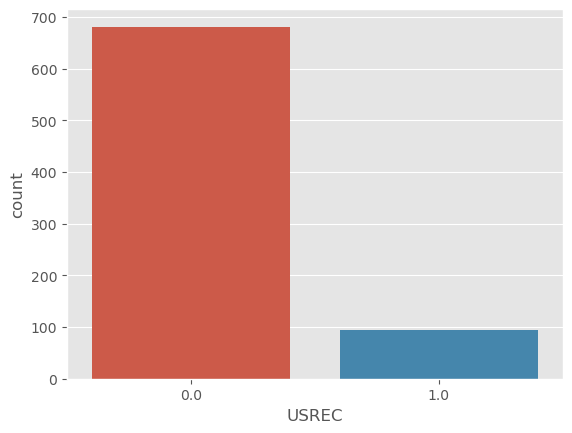

In [8]:
sns.countplot(x= "USREC",data=df)
plt.show()

------------------

## Linear Models 



### Probit

In [9]:
X = df.drop(['USREC','date'],axis=1)
y = df['USREC']

In [10]:

X_norm = mms.fit_transform(X)
X_scaled = scaler.fit_transform(X)

In [11]:
probit_model=smf.Probit(y,X)
result=probit_model.fit()
print(result.summary2())

         Current function value: 0.322742
         Iterations: 35
                                 Results: Probit
Model:                     Probit                Pseudo R-squared:      0.132    
Dependent Variable:        USREC                 AIC:                   698.8952 
Date:                      2023-11-08 00:03      BIC:                   1159.6563
No. Observations:          776                   Log-Likelihood:        -250.45  
Df Model:                  98                    LL-Null:               -288.46  
Df Residuals:              677                   LLR p-value:           0.95123  
Converged:                 0.0000                Scale:                 1.0000   
No. Iterations:            35.0000                                               
---------------------------------------------------------------------------------
                  Coef.      Std.Err.      z    P>|z|      [0.025       0.975]   
-----------------------------------------------------------------

/home/eduardo/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [12]:
probit_model=smf.Probit(y,X_norm)
result=probit_model.fit(maxiter=1000)
print(result.summary2())

Optimization terminated successfully.
         Current function value: nan
         Iterations 13
                       Results: Probit
Model:              Probit           Pseudo R-squared: nan    
Dependent Variable: USREC            AIC:              nan    
Date:               2023-11-08 00:03 BIC:              nan    
No. Observations:   776              Log-Likelihood:   nan    
Df Model:           99               LL-Null:          -288.46
Df Residuals:       676              LLR p-value:      nan    
Converged:          1.0000           Scale:            1.0000 
No. Iterations:     13.0000                                   
-----------------------------------------------------------------
            Coef.    Std.Err.     z     P>|z|    [0.025    0.975]
-----------------------------------------------------------------
x1            nan         nan    nan      nan       nan       nan
x2            nan         nan    nan      nan       nan       nan
x3            nan         nan

/home/eduardo/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:2201: RuntimeWarning: divide by zero encountered in divide
  L = q*self.pdf(q*XB)/self.cdf(q*XB)
/home/eduardo/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:2201: RuntimeWarning: invalid value encountered in divide
  L = q*self.pdf(q*XB)/self.cdf(q*XB)
/home/eduardo/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:2202: RuntimeWarning: invalid value encountered in multiply
  return np.dot(-L*(L+XB)*X.T,X)


In [13]:
probit_model=smf.Probit(y,X_scaled)
result=probit_model.fit()
print(result.summary2())

         Current function value: 0.253564
         Iterations: 35
                           Results: Probit
Model:                Probit            Pseudo R-squared:  0.318     
Dependent Variable:   USREC             AIC:               591.5309  
Date:                 2023-11-08 00:03  BIC:               1052.2920 
No. Observations:     776               Log-Likelihood:    -196.77   
Df Model:             98                LL-Null:           -288.46   
Df Residuals:         677               LLR p-value:       3.8774e-07
Converged:            0.0000            Scale:             1.0000    
No. Iterations:       35.0000                                        
---------------------------------------------------------------------
       Coef.     Std.Err.      z    P>|z|      [0.025       0.975]   
---------------------------------------------------------------------
x1      4.4097       3.9382  1.1197 0.2628       -3.3091      12.1284
x2      1.8556       7.8460  0.2365 0.8130      -13

/home/eduardo/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [14]:
from sklearn import metrics



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=SPLIT, random_state=SEED, stratify=y)


X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)


probit=smf.Probit(y,X)
probit.fit(maxiter=500)
print(probit.fit().summary2())

Optimization terminated successfully.
         Current function value: nan
         Iterations 42
         Current function value: 0.322742
         Iterations: 35
                                 Results: Probit
Model:                     Probit                Pseudo R-squared:      0.132    
Dependent Variable:        USREC                 AIC:                   698.8952 
Date:                      2023-11-08 00:03      BIC:                   1159.6563
No. Observations:          776                   Log-Likelihood:        -250.45  
Df Model:                  98                    LL-Null:               -288.46  
Df Residuals:              677                   LLR p-value:           0.95123  
Converged:                 0.0000                Scale:                 1.0000   
No. Iterations:            35.0000                                               
---------------------------------------------------------------------------------
                  Coef.      Std.Err.      z    P

/home/eduardo/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:2201: RuntimeWarning: divide by zero encountered in divide
  L = q*self.pdf(q*XB)/self.cdf(q*XB)
/home/eduardo/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:2201: RuntimeWarning: invalid value encountered in divide
  L = q*self.pdf(q*XB)/self.cdf(q*XB)
/home/eduardo/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Logistic  Regression

Accuracy  - Train :  0.944
Accuracy  - Test :  0.9154
----------------------------------------------------------------------------------------------------
Precision  - Train :  0.6923
Precision  - Test :  0.6
----------------------------------------------------------------------------------------------------
Recall  - Train :  0.9643
Recall  - Test :  0.9403
----------------------------------------------------------------------------------------------------
F1-Score  - Train :  0.806
F1-Score  - Test :  0.7326
----------------------------------------------------------------------------------------------------
Area Under the Curve  - Train :  0.9835
Area Under the Curve  - Test :  0.9753
----------------------------------------------------------------------------------------------------
Gini  - Train :  0.97
Gini  - Test :  0.95
----------------------------------------------------------------------------------------------------


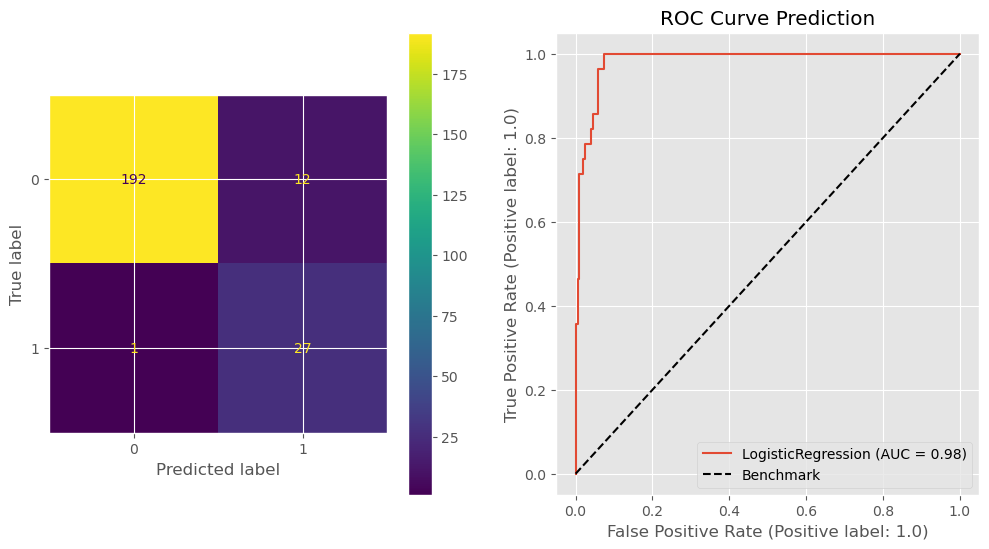

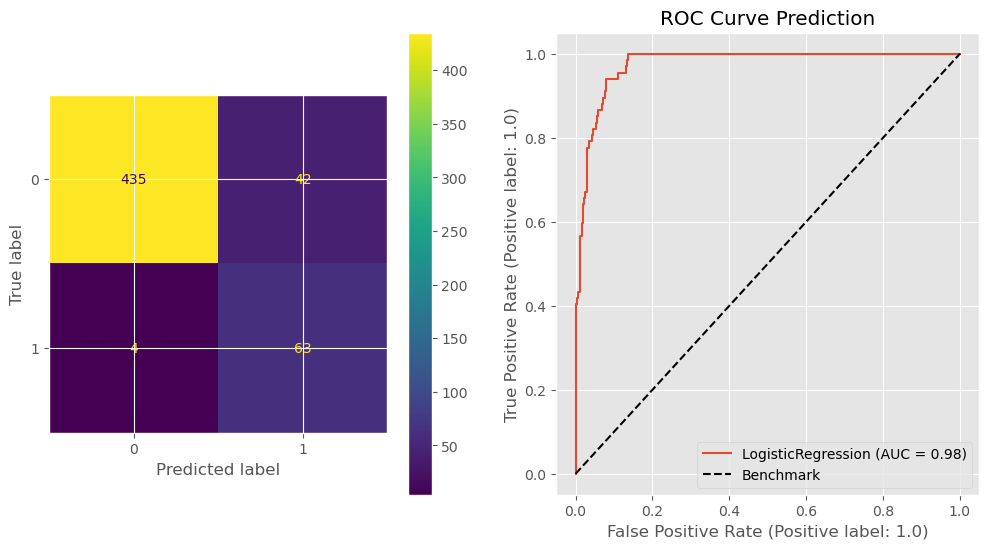

In [15]:
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=SPLIT, random_state=SEED, stratify=y)

log_reg = LogisticRegression(class_weight='balanced',solver='liblinear',random_state = SEED)




X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

log_reg.fit(X_train_norm, y_train)

train_metrics = me.get_metrics(log_reg,y_train,X_train_norm )
test_metrics = me.get_metrics(log_reg,y_test,X_test_norm )
me.display_metrics(train_metrics,test_metrics)

me.plot_classification_metrics(log_reg,y_train,X_train_norm )
me.plot_classification_metrics(log_reg,y_test,X_test_norm )



In [16]:
feature_importance_log_reg = pd.DataFrame({"Varariables":X.columns,"Coefs":log_reg.coef_[0]})


In [17]:
help(LogisticRegression)

Help on class LogisticRegression in module sklearn.linear_model._logistic:

class LogisticRegression(sklearn.linear_model._base.LinearClassifierMixin, sklearn.linear_model._base.SparseCoefMixin, sklearn.base.BaseEstimator)
 |  LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
 |  
 |  Logistic Regression (aka logit, MaxEnt) classifier.
 |  
 |  In the multiclass case, the training algorithm uses the one-vs-rest (OvR)
 |  scheme if the 'multi_class' option is set to 'ovr', and uses the
 |  cross-entropy loss if the 'multi_class' option is set to 'multinomial'.
 |  (Currently the 'multinomial' option is supported only by the 'lbfgs',
 |  'sag', 'saga' and 'newton-cg' solvers.)
 |  
 |  This class implements regularized logistic regression using the
 |  'liblinear' library, 'newton-cg', 's

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/linea

Accuracy  - Train :  0.9483
Accuracy  - Test :  0.9154
----------------------------------------------------------------------------------------------------
Precision  - Train :  0.7
Precision  - Test :  0.6019
----------------------------------------------------------------------------------------------------
Recall  - Train :  1.0
Recall  - Test :  0.9254
----------------------------------------------------------------------------------------------------
F1-Score  - Train :  0.8235
F1-Score  - Test :  0.7294
----------------------------------------------------------------------------------------------------
Area Under the Curve  - Train :  0.9886
Area Under the Curve  - Test :  0.9799
----------------------------------------------------------------------------------------------------
Gini  - Train :  0.98
Gini  - Test :  0.96
----------------------------------------------------------------------------------------------------


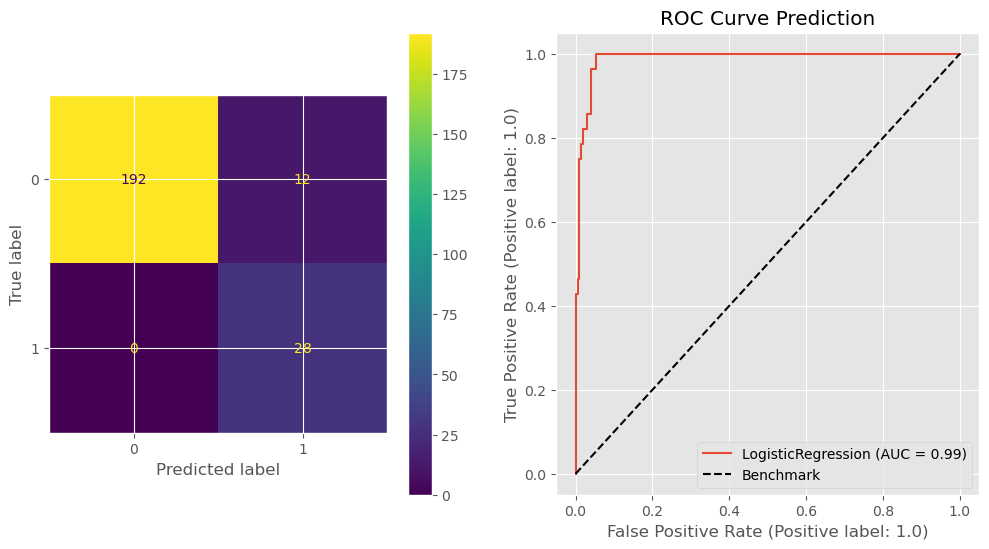

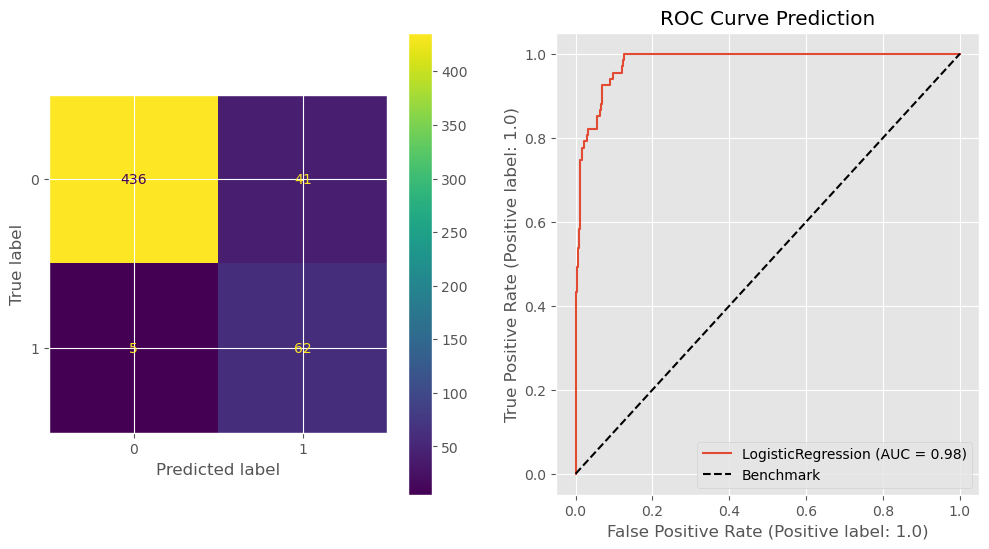

In [18]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=SPLIT, random_state=SEED, stratify=y)



X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)



strat_kfold = StratifiedKFold(n_splits=10, shuffle=False)

params_log_reg = {
    'C': [0.001, 0.01, 0.1, 1, 5,10,8,30,50, 100, 1000],
    'penalty': ['elasticnet', 'l1', 'l2'],
    "solver":['saga',"lblinear"]
}



# Step 2: Perform cross-validation with hyperparameter tuning

grid_search_log_reg = GridSearchCV(LogisticRegression(class_weight='balanced',random_state = SEED), params_log_reg, cv=strat_kfold, scoring='roc_auc',n_jobs=-1)
grid_search_log_reg.fit(X_train_norm, y_train)


best_log_reg = grid_search_log_reg.best_estimator_

best_log_reg.fit(X_train_norm, y_train)

train_metrics = me.get_metrics(best_log_reg,y_train,X_train_norm )
test_metrics = me.get_metrics(best_log_reg,y_test,X_test_norm )
me.display_metrics(train_metrics,test_metrics)

me.plot_classification_metrics(best_log_reg,y_train,X_train_norm )
me.plot_classification_metrics(best_log_reg,y_test,X_test_norm )



In [19]:
grid_search_log_reg.best_estimator_

LogisticRegression(C=10, class_weight='balanced', random_state=42,
                   solver='saga')

In [20]:
grid_search_log_reg.best_params_['penalty']

'l2'

In [21]:
grid_search_log_reg.best_params_

{'C': 10, 'penalty': 'l2', 'solver': 'saga'}

In [22]:
grid_search_log_reg. best_score_

0.9742857142857142

### SVM Linear

Accuracy  - Train :  0.9655
Accuracy  - Test :  0.9485
----------------------------------------------------------------------------------------------------
Precision  - Train :  0.8846
Precision  - Test :  0.8
----------------------------------------------------------------------------------------------------
Recall  - Train :  0.8214
Recall  - Test :  0.7761
----------------------------------------------------------------------------------------------------
F1-Score  - Train :  0.8519
F1-Score  - Test :  0.7879
----------------------------------------------------------------------------------------------------
Area Under the Curve  - Train :  0.9939
Area Under the Curve  - Test :  0.9815
----------------------------------------------------------------------------------------------------
Gini  - Train :  0.99
Gini  - Test :  0.96
----------------------------------------------------------------------------------------------------


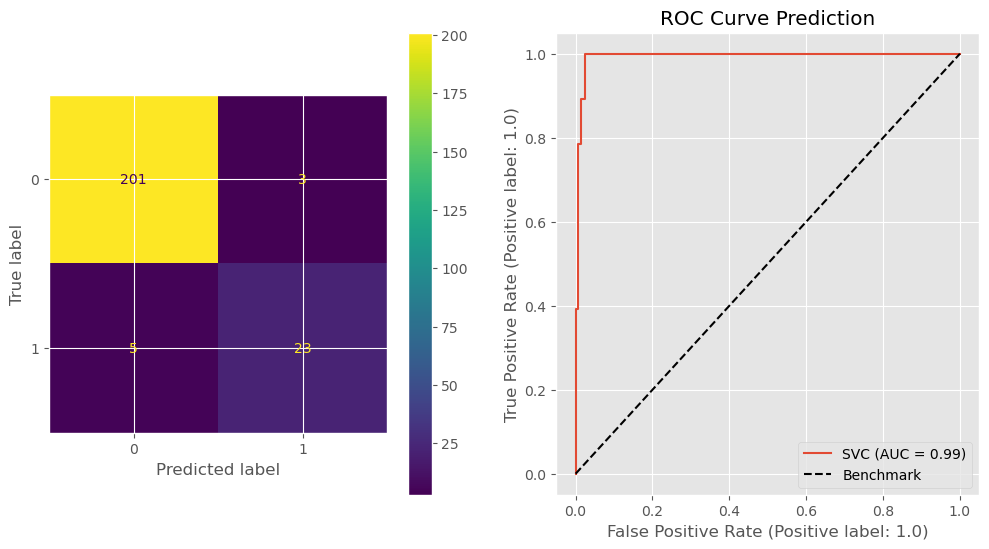

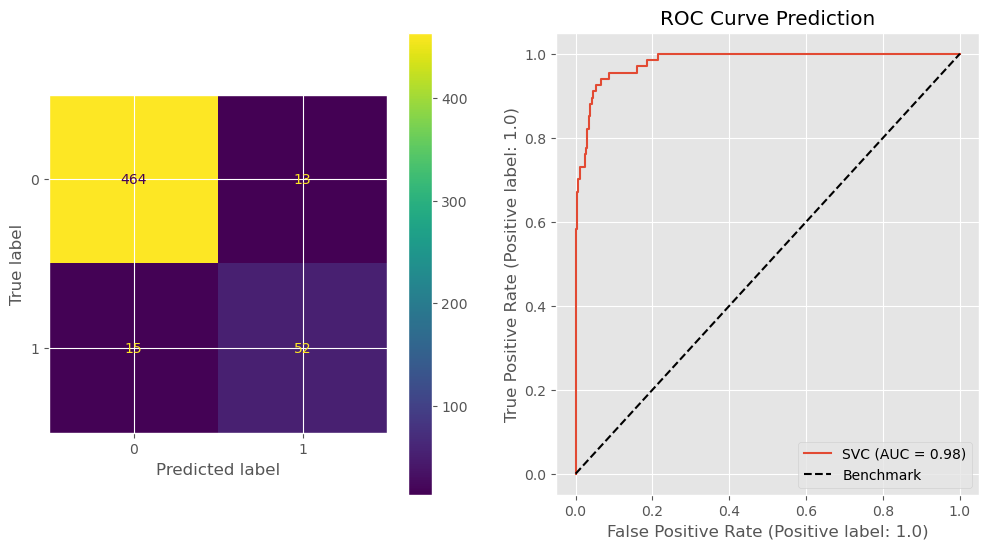

In [24]:
from sklearn.svm import SVC
import utils_FRED_MD.model_evaluation_gpt as me_gpt

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=SPLIT, random_state=SEED, stratify=y)



X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)



strat_kfold = StratifiedKFold(n_splits=10, shuffle=False)

params_svm_linear = {
    'C': [0.001, 0.01, 0.1, 1, 5,10,8,30,50, 100, 1000]
}



# Step 2: Perform cross-validation with hyperparameter tuning

grid_search_svm_linear = GridSearchCV(SVC(kernel='linear',random_state = SEED), params_svm_linear, cv=strat_kfold, scoring='roc_auc',n_jobs=-1)
grid_search_svm_linear.fit(X_train_norm, y_train)


best_svm_linear = grid_search_svm_linear.best_estimator_

best_svm_linear.fit(X_train_norm, y_train)

train_metrics = me_gpt.get_metrics(best_svm_linear,y_train,X_train_norm )
test_metrics = me_gpt.get_metrics(best_svm_linear,y_test,X_test_norm )
me_gpt.display_metrics(train_metrics,test_metrics)

me_gpt.plot_classification_metrics(best_svm_linear,y_train,X_train_norm )
me_gpt.plot_classification_metrics(best_svm_linear,y_test,X_test_norm )



In [25]:
grid_search_svm_linear.best_params_

{'C': 8}

### SVM Kernel trick

Accuracy  - Train :  0.9914
Accuracy  - Test :  0.9632
----------------------------------------------------------------------------------------------------
Precision  - Train :  1.0
Precision  - Test :  0.873
----------------------------------------------------------------------------------------------------
Recall  - Train :  0.9286
Recall  - Test :  0.8209
----------------------------------------------------------------------------------------------------
F1-Score  - Train :  0.963
F1-Score  - Test :  0.8462
----------------------------------------------------------------------------------------------------
Area Under the Curve  - Train :  1.0
Area Under the Curve  - Test :  0.9854
----------------------------------------------------------------------------------------------------
Gini  - Train :  1.0
Gini  - Test :  0.97
----------------------------------------------------------------------------------------------------


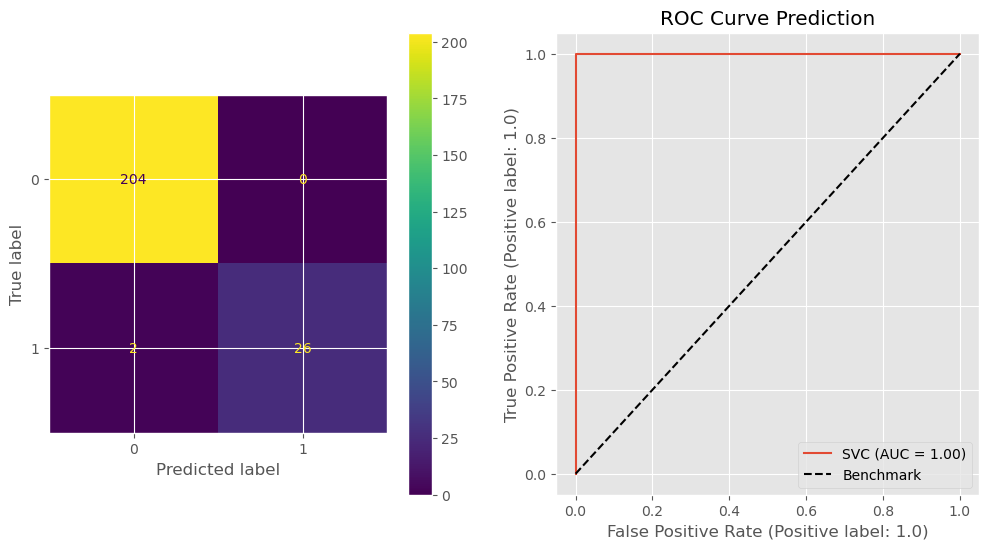

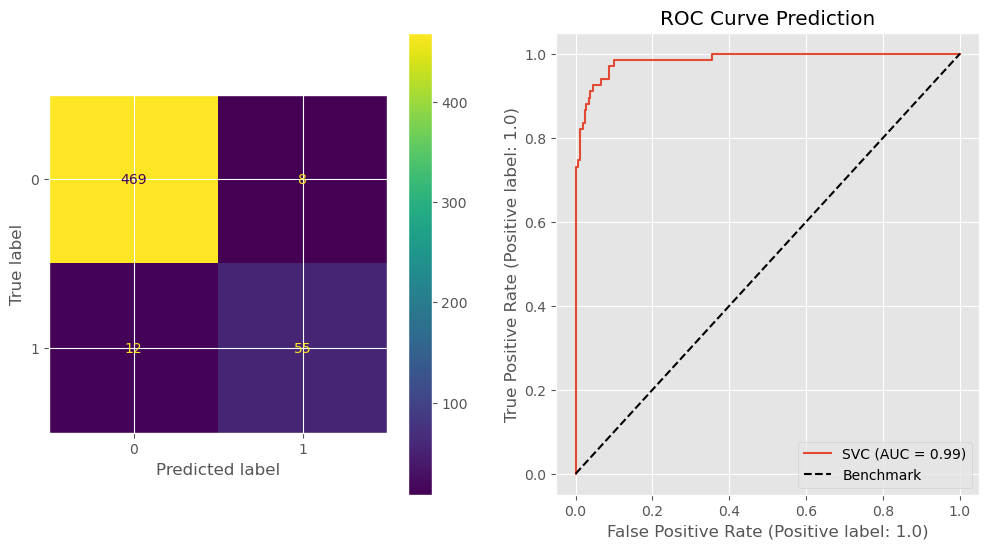

In [26]:
from sklearn.svm import SVC
import utils_FRED_MD.model_evaluation_gpt as me_gpt

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=SPLIT, random_state=SEED, stratify=y)



X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)



strat_kfold = StratifiedKFold(n_splits=10, shuffle=False)

params_svm_kernel = {
    'C': [0.001, 0.01, 0.1, 1, 5,10,8,30,50, 100, 1000]
}



# Step 2: Perform cross-validation with hyperparameter tuning

grid_search_svm_kernel = GridSearchCV(SVC(kernel='rbf',random_state = SEED), params_svm_kernel, cv=strat_kfold, scoring='roc_auc',n_jobs=-1)
grid_search_svm_kernel.fit(X_train_norm, y_train)


best_svm_kernel = grid_search_svm_kernel.best_estimator_

best_svm_kernel.fit(X_train_norm, y_train)

train_metrics = me_gpt.get_metrics(best_svm_kernel,y_train,X_train_norm )
test_metrics = me_gpt.get_metrics(best_svm_kernel,y_test,X_test_norm )
me_gpt.display_metrics(train_metrics,test_metrics)

me_gpt.plot_classification_metrics(best_svm_kernel,y_train,X_train_norm )
me_gpt.plot_classification_metrics(best_svm_kernel,y_test,X_test_norm )



In [27]:
grid_search_svm_kernel.best_params_

{'C': 50}

### Decision trees

Accuracy  - Train :  0.9784
Accuracy  - Test :  0.9026
----------------------------------------------------------------------------------------------------
Precision  - Train :  0.9259
Precision  - Test :  0.6029
----------------------------------------------------------------------------------------------------
Recall  - Train :  0.8929
Recall  - Test :  0.6119
----------------------------------------------------------------------------------------------------
F1-Score  - Train :  0.9091
F1-Score  - Test :  0.6074
----------------------------------------------------------------------------------------------------
Area Under the Curve  - Train :  0.9975
Area Under the Curve  - Test :  0.8117
----------------------------------------------------------------------------------------------------
Gini  - Train :  0.99
Gini  - Test :  0.62
----------------------------------------------------------------------------------------------------


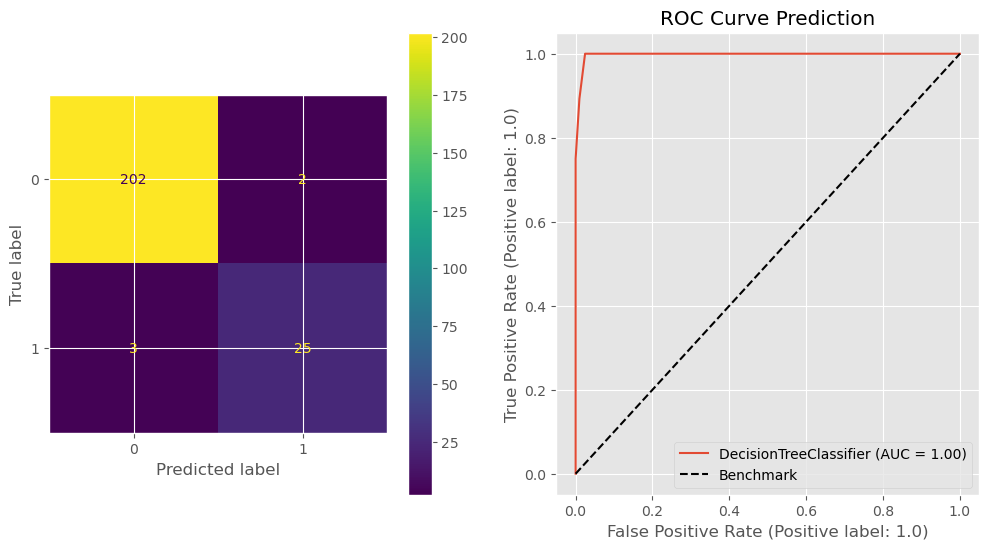

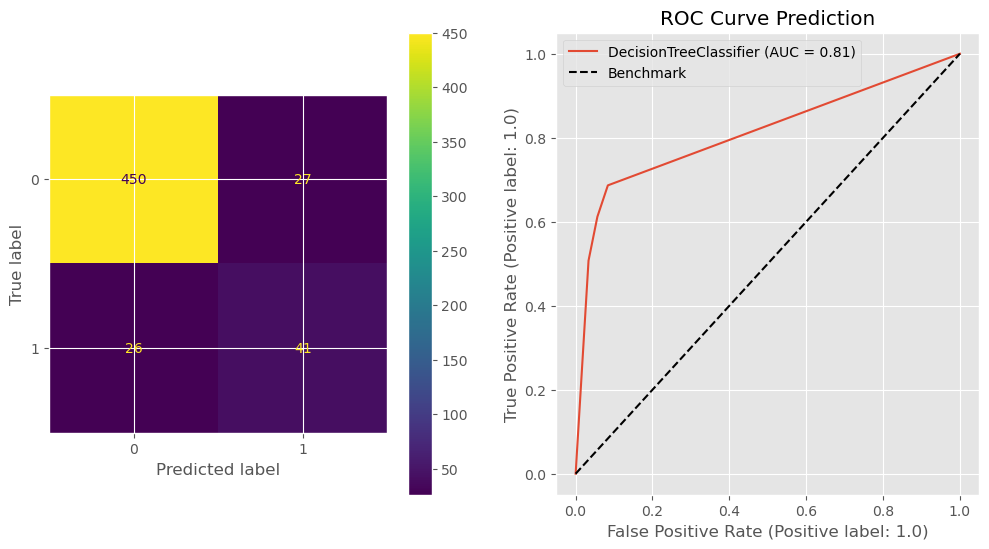

In [28]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=SPLIT, random_state=SEED, stratify=y)



X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

strat_kfold = StratifiedKFold(n_splits=10, shuffle=False)

params_decision_tree = {
    'criterion': ['gini', 'entropy','log_loss'],
    'max_depth': [None, 10,30, 60, 90],
    'min_samples_split': [2, 5, 10, 20, 50],
    'min_samples_leaf': [1, 2, 4, 8, 16],
    'max_features': ['auto', 'sqrt', 'log2', None]
}




# Step 2: Perform cross-validation with hyperparameter tuning

grid_search_DT = GridSearchCV(DecisionTreeClassifier(random_state = SEED), params_decision_tree, cv=strat_kfold, scoring='roc_auc',n_jobs=-1)
grid_search_DT.fit(X_train_norm, y_train)


best_DT = grid_search_DT.best_estimator_

best_DT.fit(X_train_norm, y_train)

train_metrics = me.get_metrics(best_DT,y_train,X_train_norm )
test_metrics = me.get_metrics(best_DT,y_test,X_test_norm )
me.display_metrics(train_metrics,test_metrics)

me.plot_classification_metrics(best_DT,y_train,X_train_norm )
me.plot_classification_metrics(best_DT,y_test,X_test_norm )



### Random Forests

Accuracy  - Train :  1.0
Accuracy  - Test :  0.943
----------------------------------------------------------------------------------------------------
Precision  - Train :  1.0
Precision  - Test :  0.8913
----------------------------------------------------------------------------------------------------
Recall  - Train :  1.0
Recall  - Test :  0.6119
----------------------------------------------------------------------------------------------------
F1-Score  - Train :  1.0
F1-Score  - Test :  0.7257
----------------------------------------------------------------------------------------------------
Area Under the Curve  - Train :  1.0
Area Under the Curve  - Test :  0.9861
----------------------------------------------------------------------------------------------------
Gini  - Train :  1.0
Gini  - Test :  0.97
----------------------------------------------------------------------------------------------------


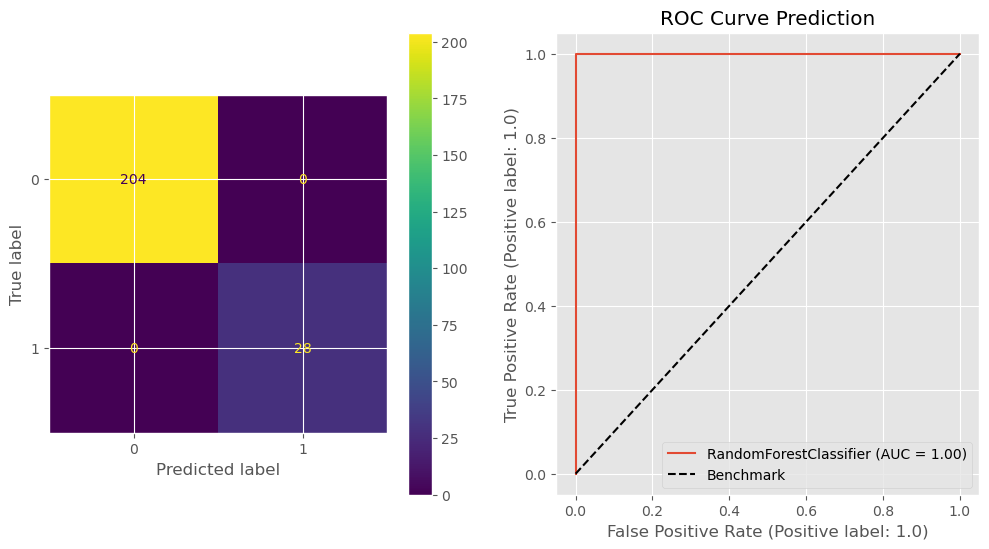

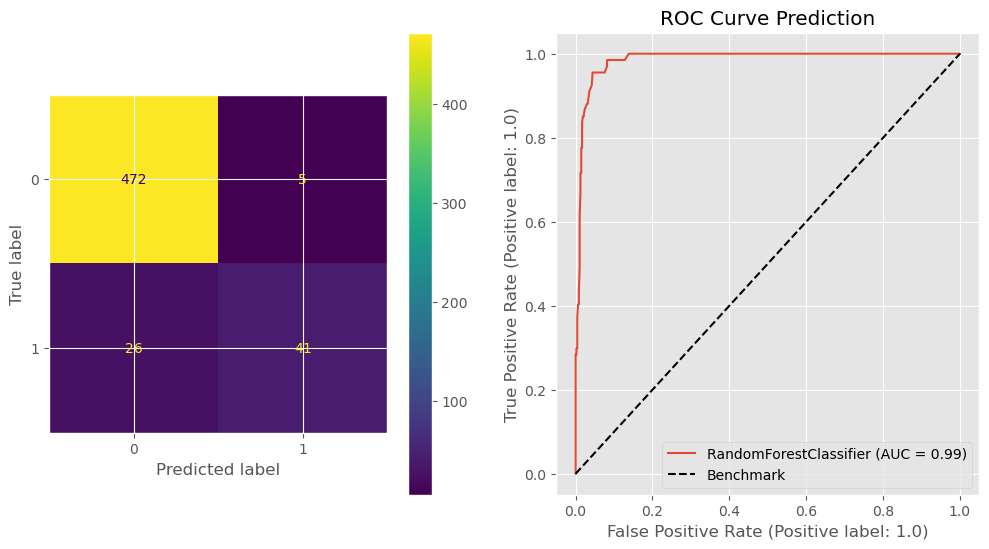

In [29]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=SPLIT, random_state=SEED, stratify=y)



X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

strat_kfold = StratifiedKFold(n_splits=10, shuffle=False)

params_random_forest = {
    'n_estimators': [10, 50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}





# Step 2: Perform cross-validation with hyperparameter tuning

grid_search_RF = GridSearchCV(RandomForestClassifier(random_state=SEED), params_decision_tree, cv=strat_kfold, scoring='roc_auc',n_jobs=-1)
grid_search_RF.fit(X_train_norm, y_train)


best_RF = grid_search_RF.best_estimator_

best_RF.fit(X_train_norm, y_train)

train_metrics = me.get_metrics(best_RF,y_train,X_train_norm )
test_metrics = me.get_metrics(best_RF,y_test,X_test_norm )
me.display_metrics(train_metrics,test_metrics)

me.plot_classification_metrics(best_RF,y_train,X_train_norm )
me.plot_classification_metrics(best_RF,y_test,X_test_norm )

